In [26]:
import numpy as np
import pandas as pd

# ⚙️ ML & Preprocessing Libraries
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


In [3]:
#Load dataset
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

original = pd.read_csv("sample_submission.csv")
original['y'] = original['y'].map({'no': 0, 'yes': 1})

# Add a 'dataset' column to track source
train['dataset'] = 'train'
test['dataset'] = 'test'

original['dataset'] = 'train'



# Combine train and test datasets for unified preprocessing
df = pd.concat([train, test], axis=0).reset_index(drop=True)

# 🧾 Display dataset shape
print("Dataset shape:", df.shape)

# 👁️ Preview the data
df

Dataset shape: (1000000, 19)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,dataset
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0.0,train
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0.0,train
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0.0,train
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0.0,train
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,43,management,married,tertiary,no,0,yes,no,cellular,18,nov,65,2,-1,0,unknown,NaN,test
999996,999996,40,services,married,unknown,no,522,yes,no,cellular,19,nov,531,1,189,1,failure,NaN,test
999997,999997,63,retired,married,primary,no,33,no,no,cellular,3,jul,178,1,92,8,success,NaN,test
999998,999998,50,blue-collar,married,primary,no,2629,yes,no,unknown,30,may,163,2,-1,0,unknown,NaN,test


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id         1000000 non-null  int64  
 1   age        1000000 non-null  int64  
 2   job        1000000 non-null  object 
 3   marital    1000000 non-null  object 
 4   education  1000000 non-null  object 
 5   default    1000000 non-null  object 
 6   balance    1000000 non-null  int64  
 7   housing    1000000 non-null  object 
 8   loan       1000000 non-null  object 
 9   contact    1000000 non-null  object 
 10  day        1000000 non-null  int64  
 11  month      1000000 non-null  object 
 12  duration   1000000 non-null  int64  
 13  campaign   1000000 non-null  int64  
 14  pdays      1000000 non-null  int64  
 15  previous   1000000 non-null  int64  
 16  poutcome   1000000 non-null  object 
 17  y          750000 non-null   float64
 18  dataset    1000000 non-null  object 
dtypes

In [5]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']
Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'dataset']


In [6]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0]
missing_df

,Missing Values,Percentage
y,250000,25.0


In [7]:
df[numerical_cols].describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,750000.000000
mean,499999.500000,40.927879,1202.407136,16.116924,256.007423,2.576143,22.379557,0.299841,0.120651
std,288675.278932,10.094523,2812.750998,8.252748,272.268420,2.716302,77.219149,1.348254,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,249999.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,499999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,749999.250000,48.000000,1390.000000,21.000000,359.000000,3.000000,-1.000000,0.000000,0.000000
max,999999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [8]:
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].value_counts())


Unique values in 'job':
job
management       234177
blue-collar      227468
technician       184043
admin.           108501
services          85521
retired           46796
self-employed     25444
entrepreneur      23673
unemployed        23647
housemaid         21157
student           15634
unknown            3939
Name: count, dtype: int64

Unique values in 'marital':
marital
married     641171
single      259551
divorced     99278
Name: count, dtype: int64

Unique values in 'education':
education
secondary    535407
tertiary     303545
primary      132499
unknown       28549
Name: count, dtype: int64

Unique values in 'default':
default
no     982994
yes     17006
Name: count, dtype: int64

Unique values in 'housing':
housing
yes    547822
no     452178
Name: count, dtype: int64

Unique values in 'loan':
loan
no     859980
yes    140020
Name: count, dtype: int64

Unique values in 'contact':
contact
cellular     649117
unknown      308523
telephone     42360
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

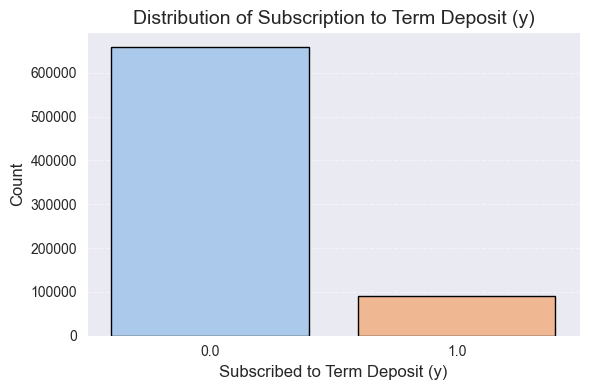


📊 Subscription to Term Deposit Value Counts (Proportions):
y
0.0    0.879
1.0    0.121
Name: proportion, dtype: float64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='y', hue='y', palette='pastel', edgecolor='black', legend=False)
plt.title('Distribution of Subscription to Term Deposit (y)', fontsize=14)
plt.xlabel('Subscribed to Term Deposit (y)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Display normalized value counts (as proportions)
print("\n📊 Subscription to Term Deposit Value Counts (Proportions):")
print(df['y'].value_counts(normalize=True).round(3))

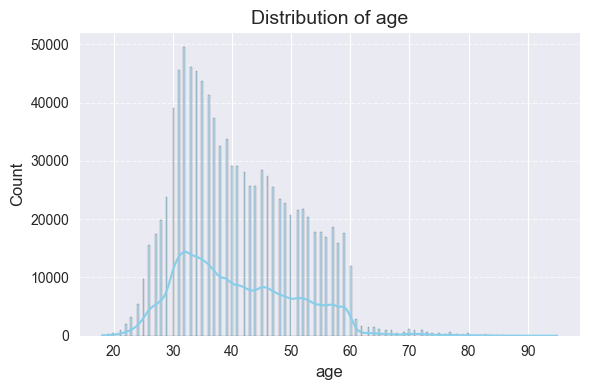


📊 Descriptive Stats for age:

count    1000000.000000
mean          40.927879
std           10.094523
min           18.000000
25%           33.000000
50%           39.000000
75%           48.000000
max           95.000000
Name: age, dtype: float64 
----------------------------------------


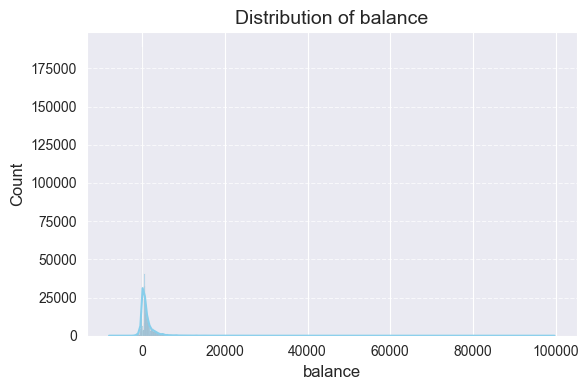


📊 Descriptive Stats for balance:

count    1000000.000000
mean        1202.407136
std         2812.750998
min        -8019.000000
25%            0.000000
50%          634.000000
75%         1390.000000
max        99717.000000
Name: balance, dtype: float64 
----------------------------------------


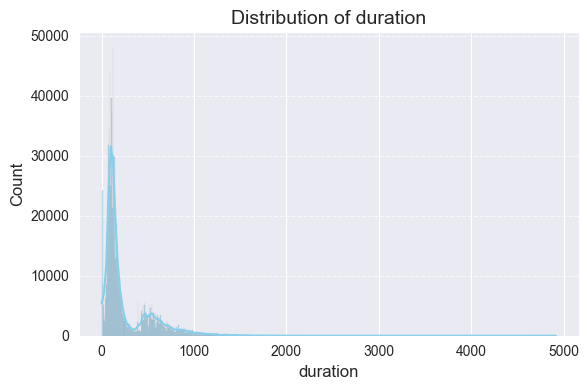


📊 Descriptive Stats for duration:

count    1000000.000000
mean         256.007423
std          272.268420
min            1.000000
25%           91.000000
50%          133.000000
75%          359.000000
max         4918.000000
Name: duration, dtype: float64 
----------------------------------------


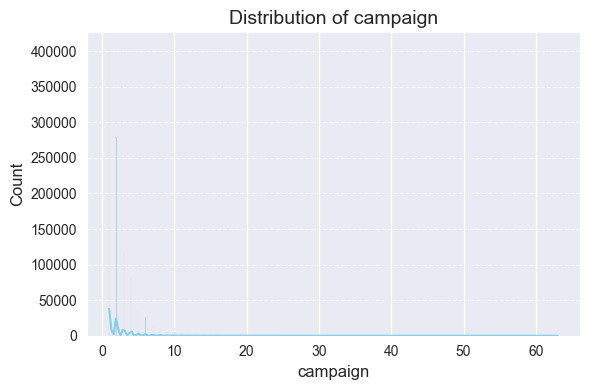


📊 Descriptive Stats for campaign:

count    1000000.000000
mean           2.576143
std            2.716302
min            1.000000
25%            1.000000
50%            2.000000
75%            3.000000
max           63.000000
Name: campaign, dtype: float64 
----------------------------------------


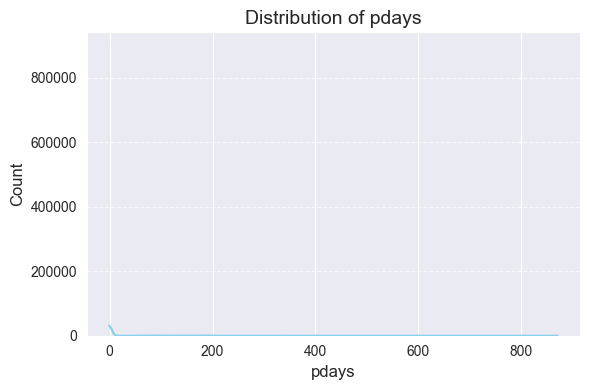


📊 Descriptive Stats for pdays:

count    1000000.000000
mean          22.379557
std           77.219149
min           -1.000000
25%           -1.000000
50%           -1.000000
75%           -1.000000
max          871.000000
Name: pdays, dtype: float64 
----------------------------------------


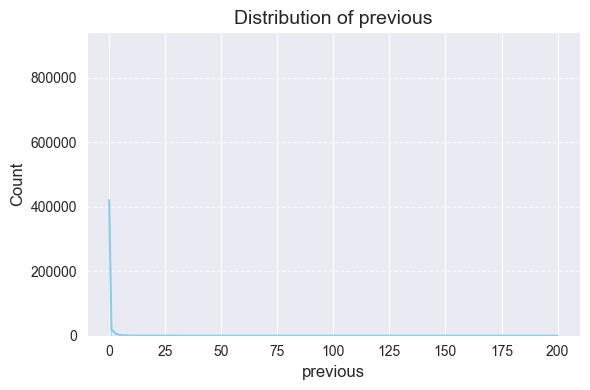


📊 Descriptive Stats for previous:

count    1000000.000000
mean           0.299841
std            1.348254
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max          200.000000
Name: previous, dtype: float64 
----------------------------------------


In [10]:
# List the numerical columns from your dataset
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print descriptive statistics
    print(f'\n📊 Descriptive Stats for {col}:\n')
    print(df[col].describe(), '\n' + '-'*40)

### Age

- Adults range from **18 up to 95**, with a **mean around 41**.
- The **middle 50%** lie between **33 and 48** — a fairly tight spread around the mean.


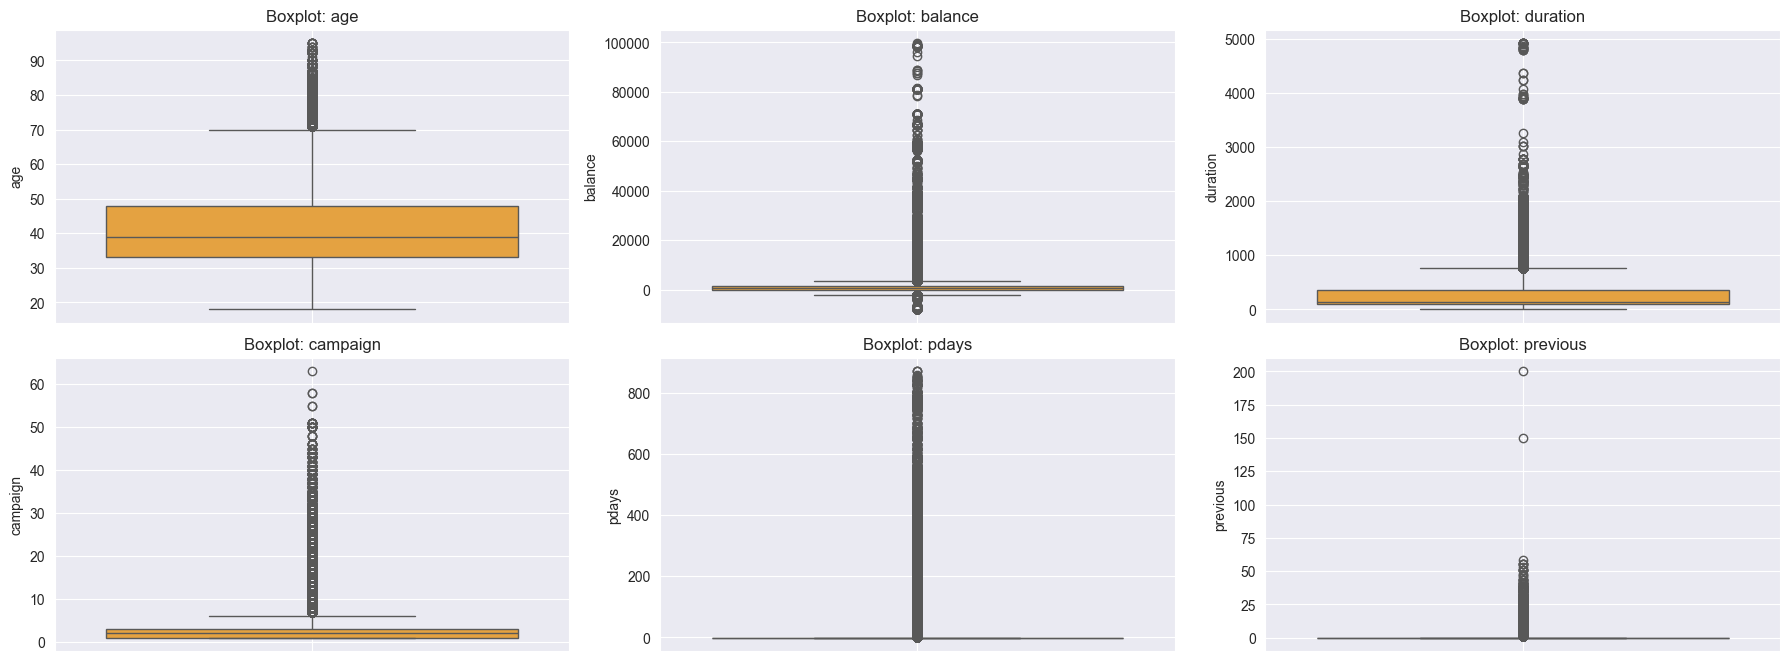

In [11]:
# 📦 Outlier Detection via Boxplots
plt.figure(figsize=(18, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=df, y=col, color='#FFA726')
    plt.title(f"Boxplot: {col}")
    plt.grid(True)
plt.tight_layout()
plt.show()

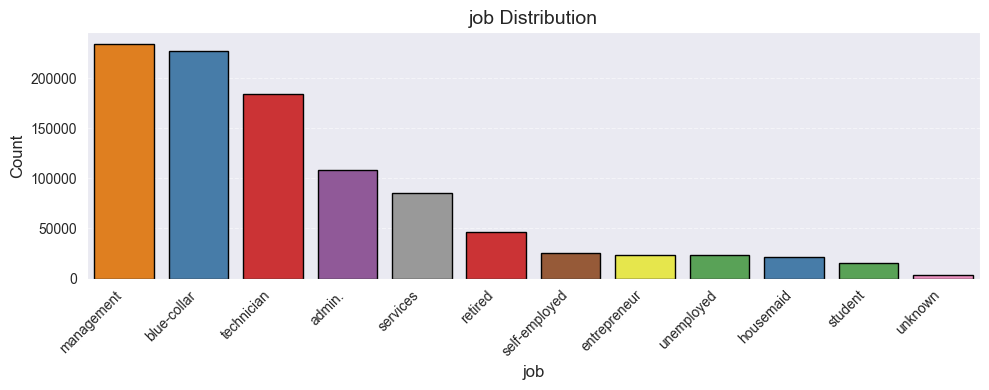


📊 Proportion of Each Category in "job":

job
management       0.234
blue-collar      0.227
technician       0.184
admin.           0.109
services         0.086
retired          0.047
self-employed    0.025
entrepreneur     0.024
unemployed       0.024
housemaid        0.021
student          0.016
unknown          0.004
Name: proportion, dtype: float64 
----------------------------------------


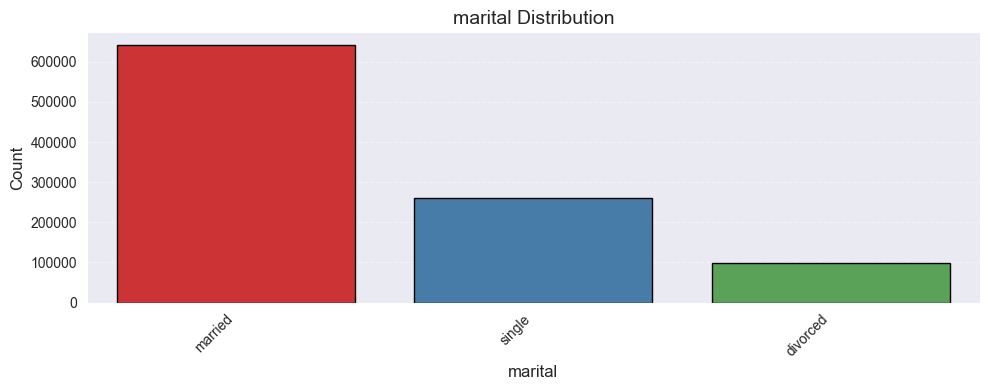


📊 Proportion of Each Category in "marital":

marital
married     0.641
single      0.260
divorced    0.099
Name: proportion, dtype: float64 
----------------------------------------


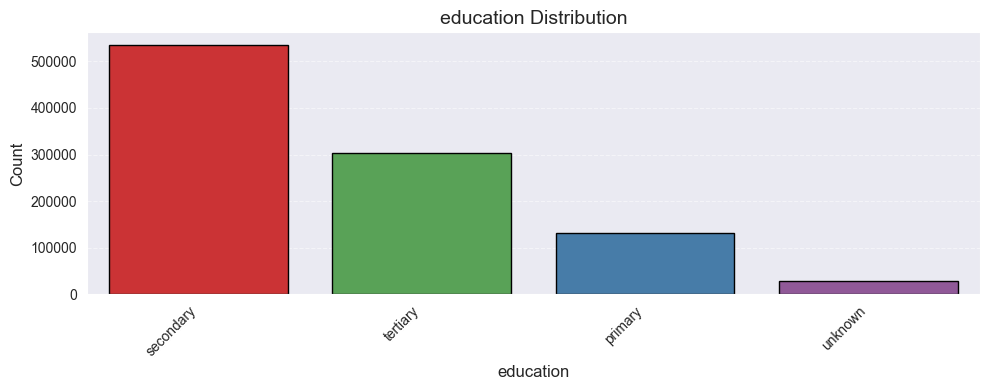


📊 Proportion of Each Category in "education":

education
secondary    0.535
tertiary     0.304
primary      0.132
unknown      0.029
Name: proportion, dtype: float64 
----------------------------------------


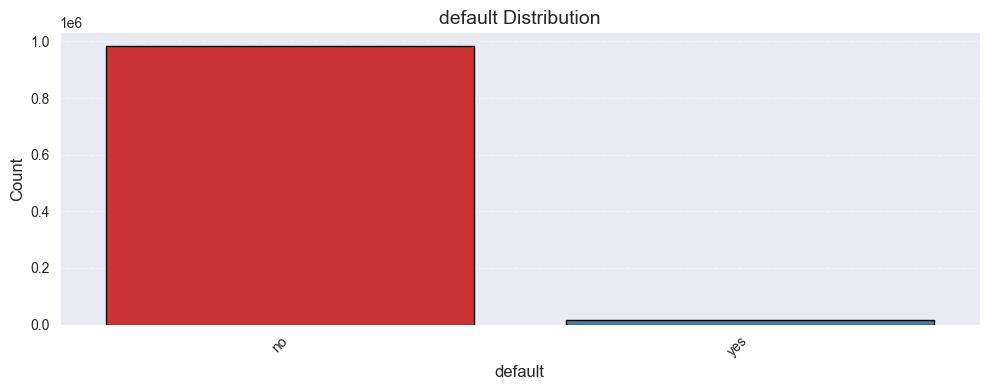


📊 Proportion of Each Category in "default":

default
no     0.983
yes    0.017
Name: proportion, dtype: float64 
----------------------------------------


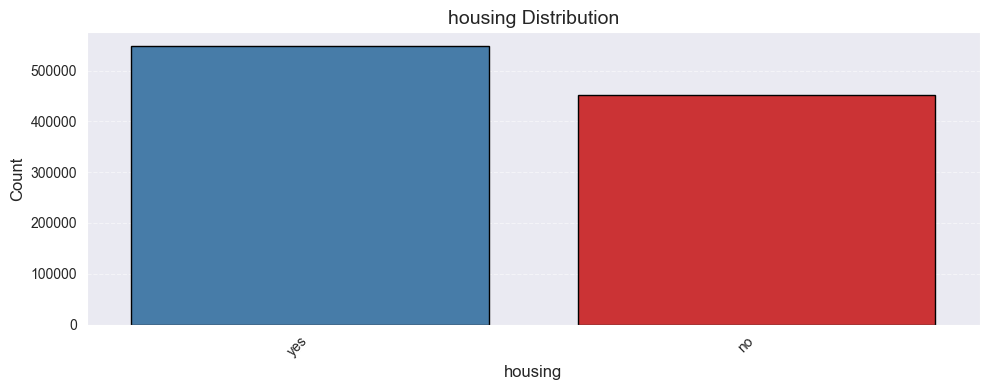


📊 Proportion of Each Category in "housing":

housing
yes    0.548
no     0.452
Name: proportion, dtype: float64 
----------------------------------------


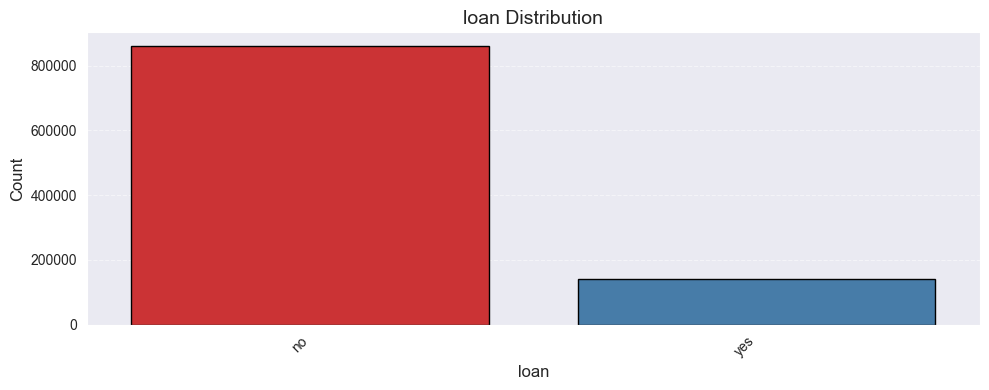


📊 Proportion of Each Category in "loan":

loan
no     0.86
yes    0.14
Name: proportion, dtype: float64 
----------------------------------------


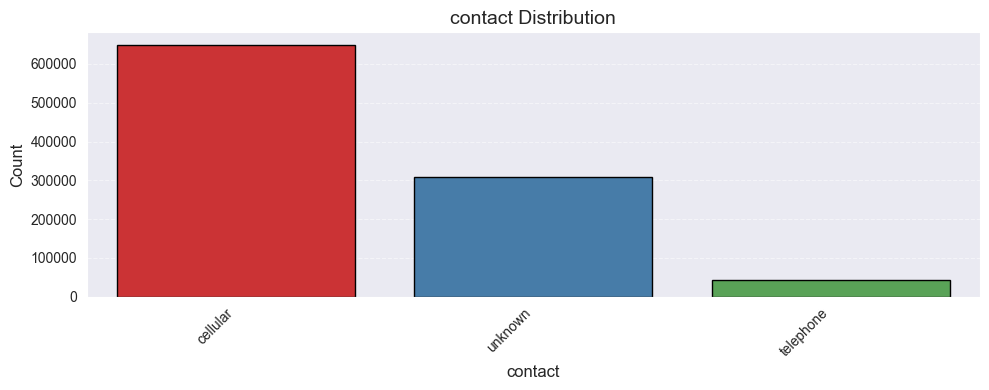


📊 Proportion of Each Category in "contact":

contact
cellular     0.649
unknown      0.309
telephone    0.042
Name: proportion, dtype: float64 
----------------------------------------


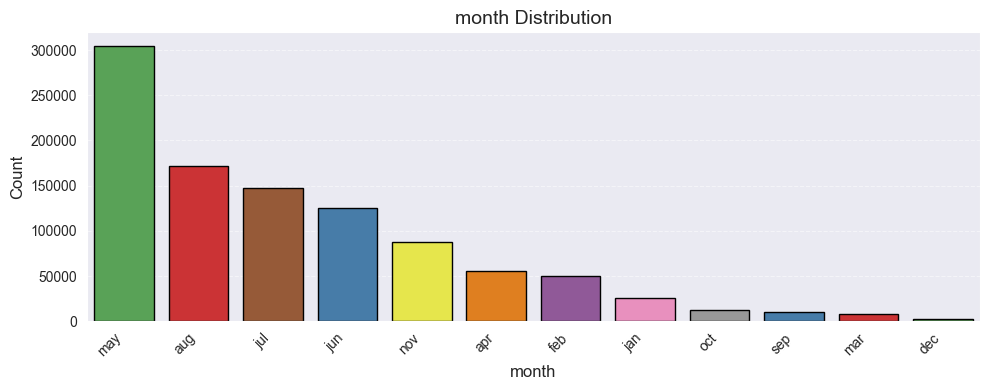


📊 Proportion of Each Category in "month":

month
may    0.304
aug    0.172
jul    0.147
jun    0.125
nov    0.088
apr    0.055
feb    0.050
jan    0.025
oct    0.012
sep    0.010
mar    0.008
dec    0.003
Name: proportion, dtype: float64 
----------------------------------------


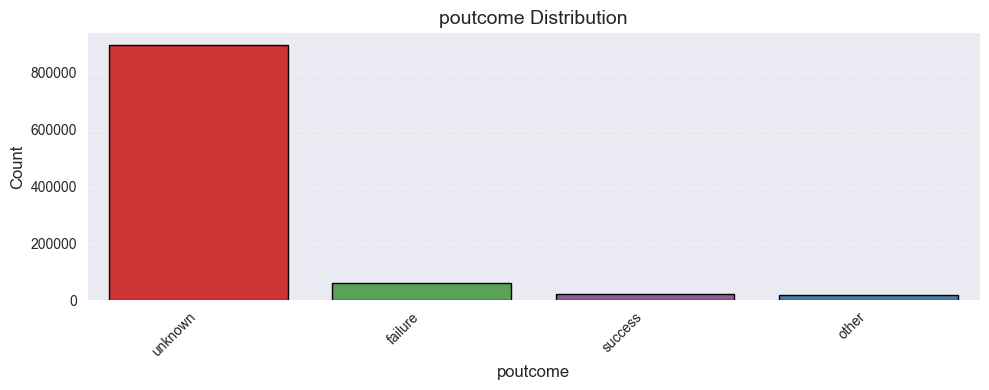


📊 Proportion of Each Category in "poutcome":

poutcome
unknown    0.897
failure    0.060
success    0.024
other      0.020
Name: proportion, dtype: float64 
----------------------------------------


In [12]:
# 📊 Distribution of Categorical Features (single bar per category; colorful; no warning)
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for col in cat_cols:
    order = df[col].value_counts().index

    plt.figure(figsize=(10, 4))
    sns.countplot(
        data=df,
        x=col,
        hue=col,                              # <-- ключевой трюк: hue совпадает с x
        order=order,
        palette='Set1',
        edgecolor='black',
        legend=False                          # скрываем легенду, чтобы не дублировалась
    )
    plt.title(f'{col} Distribution', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 🧮 Пропорции категорий
    print(f'\n📊 Proportion of Each Category in "{col}":\n')
    print(df[col].value_counts(normalize=True).round(3), '\n' + '-'*40)

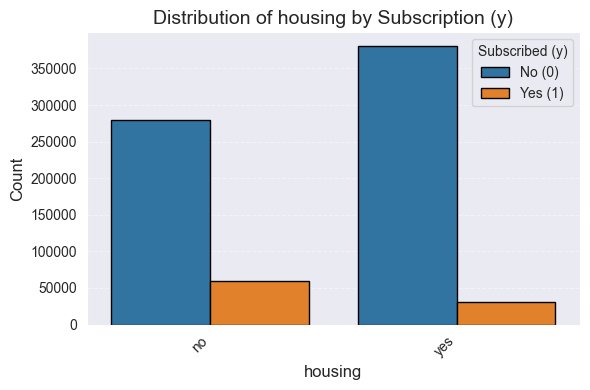

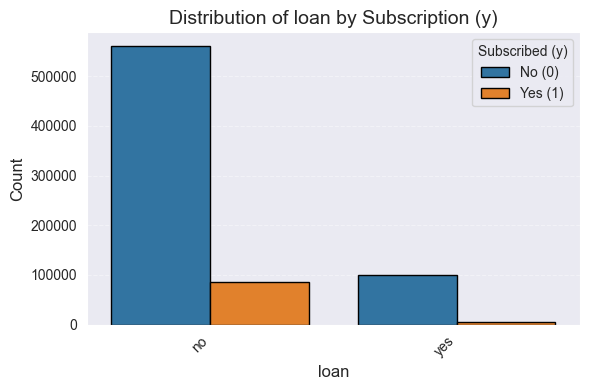

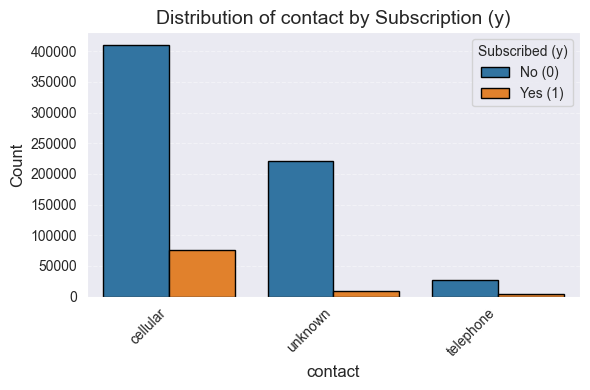

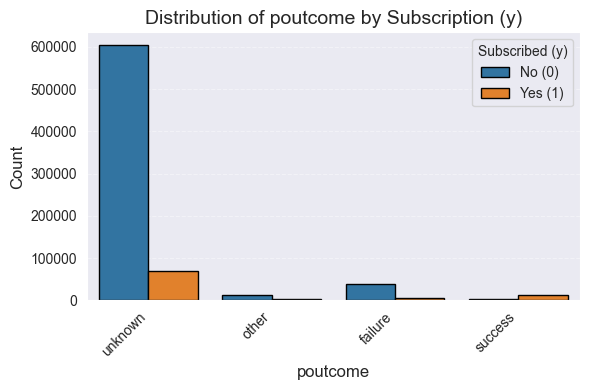

In [13]:
# 🎨 Categorical Feature Distributions by Subscription Status (y) - Custom Colors

cols_to_plot = ['housing', 'loan', 'contact', 'poutcome']
custom_palette = ['#1F77B4', '#FF7F0E']  # Blue for 0, Orange for 1

for col in cols_to_plot:
    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=df,
        x=col,
        hue='y',
        palette=custom_palette,
        edgecolor='black'
    )
    plt.title(f'Distribution of {col} by Subscription (y)', fontsize=14)
    plt.xlabel(f'{col}', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Subscribed (y)', labels=['No (0)', 'Yes (1)'])
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

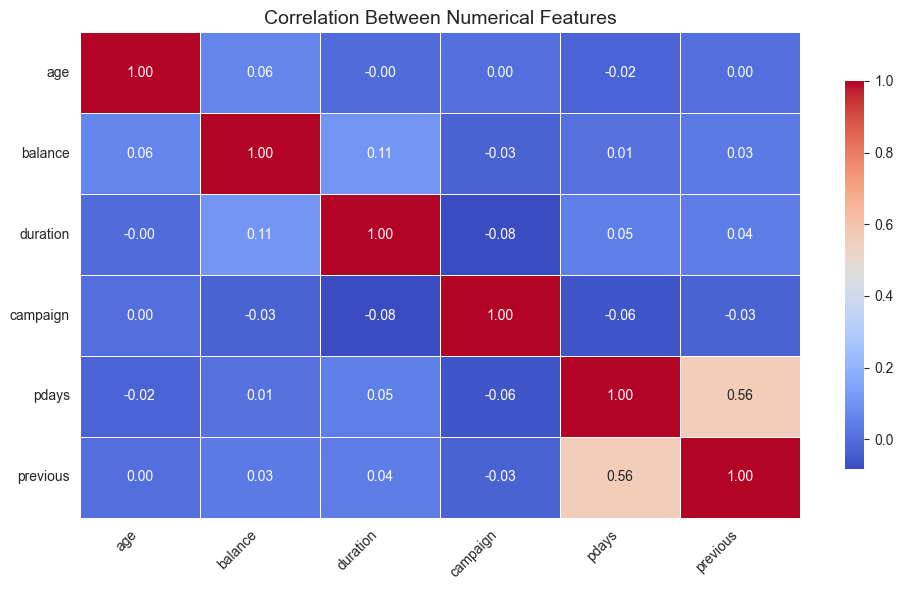

In [14]:
# 🔗 Correlation Between Numerical Features

plt.figure(figsize=(10, 6))
sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    linecolor='white',
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Between Numerical Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

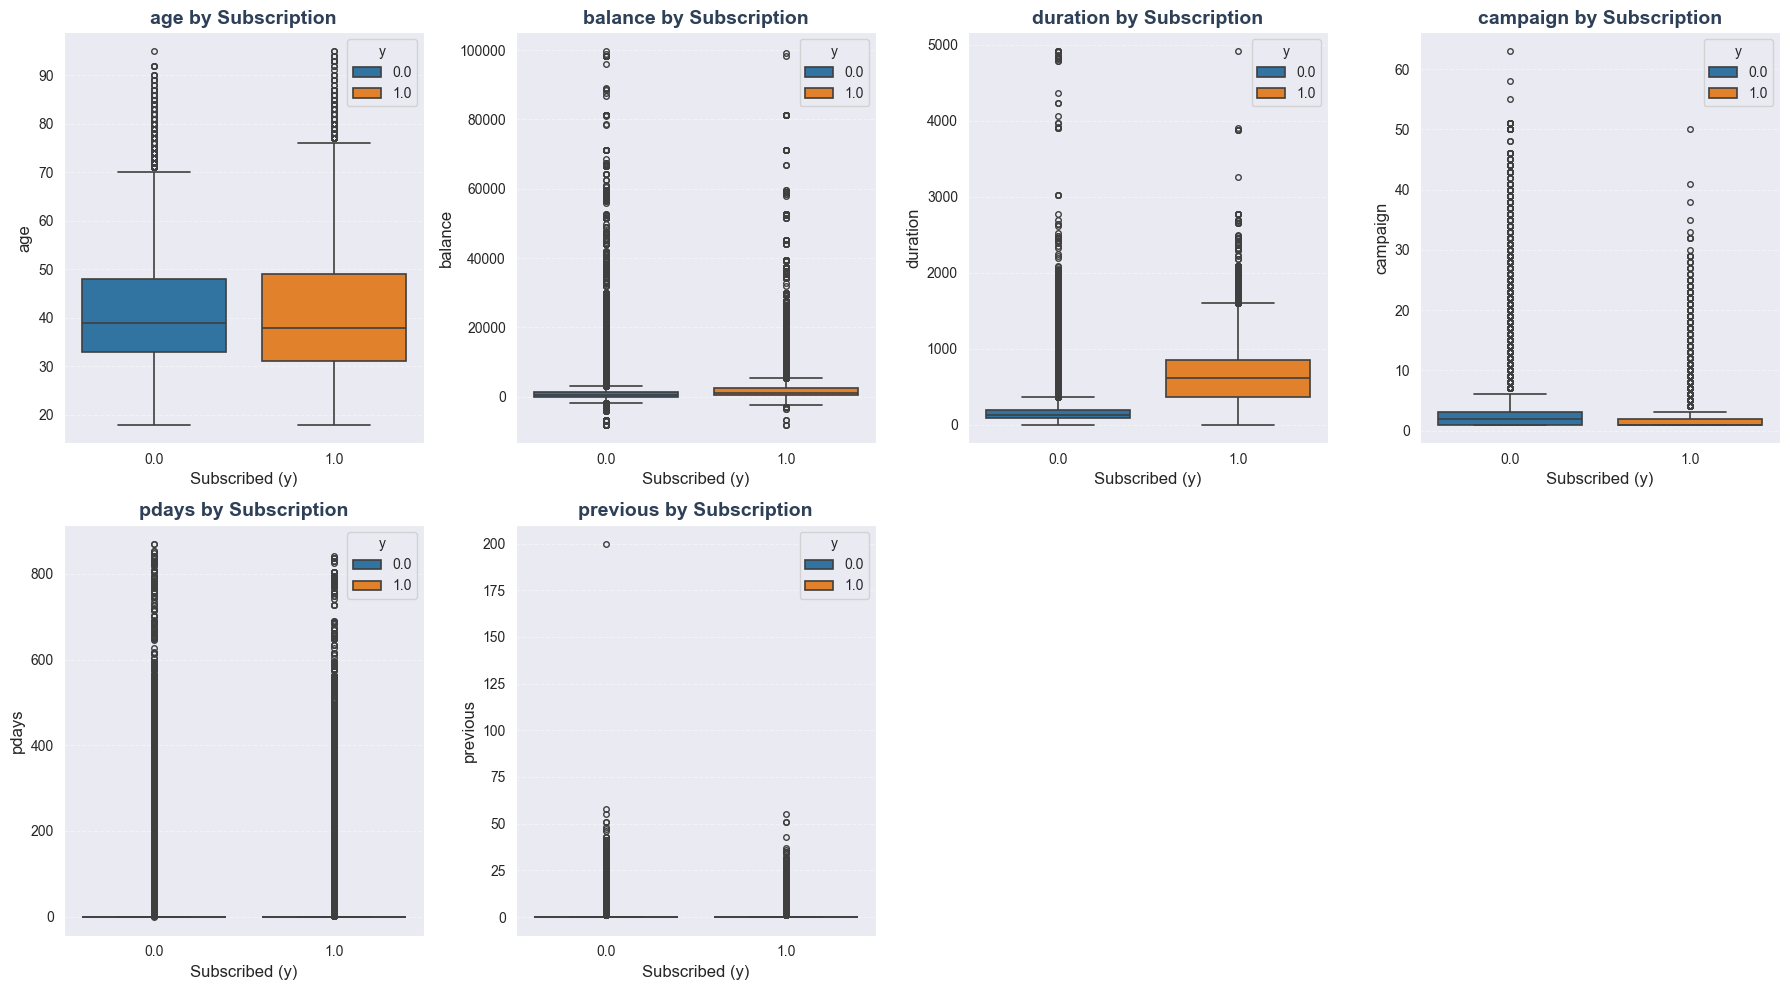

In [15]:
# 🧠 Feature vs Target Relationship (Numerical Features by Subscription)

plt.figure(figsize=(18, 10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(
        data=df,
        x='y',
        y=col,
        hue='y',
        palette=['#1F77B4', '#FF7F0E'],  # Blue for 0, Orange for 1
        linewidth=1.2,
        fliersize=4
    )
    plt.title(f'{col} by Subscription', fontsize=14, fontweight='semibold', color='#2E4057')
    plt.xlabel('Subscribed (y)', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# Feature Engineering

In [16]:
# Log-transform balance and duration
df['log_balance']  = np.log1p(df['balance'] - df['balance'].min() + 1)
df['log_duration'] = np.log1p(df['duration'])

# Data Preprocessing

In [18]:
# 👀 Count "unknown" values (treated as missing in many cases)
for col in df.columns:
    if df[col].dtype == 'object':
        print(f'{col} → unknowns: {df[col].isin(["unknown"]).sum()}')

job → unknowns: 3939
marital → unknowns: 0
education → unknowns: 28549
default → unknowns: 0
housing → unknowns: 0
loan → unknowns: 0
contact → unknowns: 308523
month → unknowns: 0
poutcome → unknowns: 896565
dataset → unknowns: 0


In [19]:

binary_map = {'yes': 1, 'no': 0}
df['default'] = df['default'].map(binary_map)
df['housing'] = df['housing'].map(binary_map)
df['loan'] = df['loan'].map(binary_map)

# df['y'] = df['y'].astype(int)  # 0 or 1

multi_cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

In [20]:
df

,id,age,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,0,42,0,7,0,0,25,117,3,-1,...,False,False,False,False,False,False,False,False,False,True
1,1,38,0,514,0,0,18,185,1,-1,...,False,True,False,False,False,False,False,False,False,True
2,2,36,0,602,1,0,14,111,2,-1,...,False,False,False,True,False,False,False,False,False,True
3,3,27,0,34,1,0,28,10,2,-1,...,False,False,False,True,False,False,False,False,False,True
4,4,26,0,889,1,0,3,902,1,-1,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,43,0,0,1,0,18,65,2,-1,...,False,False,False,False,True,False,False,False,False,True
999996,999996,40,0,522,1,0,19,531,1,189,...,False,False,False,False,True,False,False,False,False,False
999997,999997,63,0,33,0,0,3,178,1,92,...,True,False,False,False,False,False,False,False,True,False
999998,999998,50,0,2629,1,0,30,163,2,-1,...,False,False,False,True,False,False,False,False,False,True


In [21]:
train_df = df[df['dataset'] == 'train'].drop(columns=['dataset'], errors='ignore')
test_df  = df[df['dataset'] == 'test'].drop(columns=['dataset'], errors='ignore')

# 🧹 Drop Unnecessary Columns
train_df = train_df.drop(columns=['id', 'balance', 'duration'], errors='ignore')  # duration is a data leak
test_df  = test_df.drop(columns=['y', 'balance', 'duration'], errors='ignore')

# 🎯 Separate Features and Target
X = train_df.drop('y', axis=1)
# y = train_df['y'].astype(int)  # ensure target is integer
y = train_df['y']

In [22]:
X

,age,default,housing,loan,day,campaign,pdays,previous,log_balance,log_duration,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,42,0,0,0,25,3,-1,0,8.990691,4.770685,...,False,False,False,False,False,False,False,False,False,True
1,38,0,0,0,18,1,-1,0,9.051931,5.225747,...,False,True,False,False,False,False,False,False,False,True
2,36,0,1,0,14,2,-1,0,9.062188,4.718499,...,False,False,False,True,False,False,False,False,False,True
3,27,0,1,0,28,2,-1,0,8.994048,2.397895,...,False,False,False,True,False,False,False,False,False,True
4,26,0,1,0,3,1,-1,0,9.094930,6.805723,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,0,0,1,4,2,-1,0,9.138092,6.914731,...,True,False,False,False,False,False,False,False,False,True
749996,69,0,0,0,19,1,-1,0,9.065546,4.477337,...,False,False,False,False,False,False,False,False,False,True
749997,50,0,1,0,17,1,-1,0,9.016513,4.736198,...,False,False,False,False,False,False,False,False,False,True
749998,32,0,0,0,26,6,-1,0,8.955061,4.691348,...,False,False,False,False,False,False,False,False,False,True


# Machine Learning

In [27]:
# Modeling without target encoding

# Parameters
n_splits = 10
random_state = 42

# Initialize K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Containers for metrics
catboost_oof_preds = np.zeros(len(X))
xgb_oof_preds      = np.zeros(len(X))
lgbm_oof_preds     = np.zeros(len(X))

catboost_auc_scores = []
xgb_auc_scores      = []
lgbm_auc_scores     = []

catboost_feature_importances = []
xgb_feature_importances      = []
lgbm_feature_importances     = []

feature_names = X.columns

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")

    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # ----- CatBoost with GPU -----
    cat_model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='AUC',
        random_seed=random_state,
        early_stopping_rounds=50,
        verbose=100,
        task_type='GPU',
        devices='0'
    )
    cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    val_pred_cat = cat_model.predict_proba(X_val)[:, 1]
    auc_cat = roc_auc_score(y_val, val_pred_cat)
    catboost_auc_scores.append(auc_cat)
    catboost_oof_preds[val_idx] = val_pred_cat
    catboost_feature_importances.append(cat_model.get_feature_importance())
    print(f"CatBoost Fold {fold} AUC: {auc_cat:.4f}")

    # ----- XGBoost with GPU -----
    import xgboost as xgb

    xgb_params = {
        'n_estimators': 8000,
        'max_leaves': 127,
        'min_child_weight': 1.5,
        'max_depth': 0,
        'grow_policy': 'lossguide',
        'learning_rate': 0.008,
        'tree_method': 'hist',
        'subsample': 0.85,
        'colsample_bylevel': 0.7,
        'colsample_bytree': 0.75,
        'colsample_bynode': 0.85,
        'sampling_method': 'gradient_based',
        'reg_alpha': 2.5,
        'reg_lambda': 0.8,
        'enable_categorical': True,
        'max_cat_to_onehot': 1,
        'device': 'cuda',
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': 0,
        'objective': 'binary:logistic',
        # 'eval_metric': 'auc'
    }

    xgb_model = xgb.XGBClassifier(**xgb_params)

    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    val_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]
    auc_xgb = roc_auc_score(y_val, val_pred_xgb)
    xgb_auc_scores.append(auc_xgb)
    xgb_oof_preds[val_idx] = val_pred_xgb
    xgb_feature_importances.append(xgb_model.feature_importances_)
    print(f"XGBoost Fold {fold} AUC: {auc_xgb:.4f}")

    # ----- LightGBM with GPU -----
    lgbm_model = lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1,
        n_estimators=40000,
        learning_rate=0.03,
        min_child_samples=83,
        subsample=0.8,
        colsample_bytree=0.6,
        num_leaves=228,
        max_depth=6,
        max_bin=3600,
        reg_alpha=3.7,
        reg_lambda=4.7,
    )
    lgbm_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    val_pred_lgbm = lgbm_model.predict_proba(X_val)[:, 1]
    auc_lgbm = roc_auc_score(y_val, val_pred_lgbm)
    lgbm_auc_scores.append(auc_lgbm)
    lgbm_oof_preds[val_idx] = val_pred_lgbm
    lgbm_feature_importances.append(lgbm_model.feature_importances_)
    print(f"LightGBM Fold {fold} AUC: {auc_lgbm:.4f}")

# Convert lists to arrays
catboost_feature_importances = np.array(catboost_feature_importances)
xgb_feature_importances      = np.array(xgb_feature_importances)
lgbm_feature_importances     = np.array(lgbm_feature_importances)

# Average feature importances across folds
avg_catboost_importance = np.mean(catboost_feature_importances, axis=0)
avg_xgb_importance      = np.mean(xgb_feature_importances, axis=0)
avg_lgbm_importance     = np.mean(lgbm_feature_importances, axis=0)

# Create DataFrames for easier interpretation
catboost_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_catboost_importance
}).sort_values(by='Importance', ascending=False)

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_xgb_importance
}).sort_values(by='Importance', ascending=False)

lgbm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_lgbm_importance
}).sort_values(by='Importance', ascending=False)

print("\n=== CatBoost Feature Importance ===")
print(catboost_importance_df)

print("\n=== XGBoost Feature Importance ===")
print(xgb_importance_df)

print("\n=== LightGBM Feature Importance ===")
print(lgbm_importance_df)

# Summary
print("\n=== Summary ===")
print(f"CatBoost Mean AUC:   {np.mean(catboost_auc_scores):.4f} ± {np.std(catboost_auc_scores):.4f}")
print(f"XGBoost Mean AUC:     {np.mean(xgb_auc_scores):.4f} ± {np.std(xgb_auc_scores):.4f}")
print(f"LightGBM Mean AUC:    {np.mean(lgbm_auc_scores):.4f} ± {np.std(lgbm_auc_scores):.4f}")


--- Fold 1 ---


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9237935	best: 0.9237935 (0)	total: 403ms	remaining: 6m 42s
100:	test: 0.9553357	best: 0.9553357 (100)	total: 1.92s	remaining: 17.1s
200:	test: 0.9601464	best: 0.9601464 (200)	total: 3.43s	remaining: 13.6s
300:	test: 0.9620147	best: 0.9620147 (300)	total: 4.89s	remaining: 11.3s
400:	test: 0.9630430	best: 0.9630430 (400)	total: 6.34s	remaining: 9.48s
500:	test: 0.9637398	best: 0.9637398 (500)	total: 7.85s	remaining: 7.82s
600:	test: 0.9642406	best: 0.9642406 (600)	total: 9.33s	remaining: 6.19s
700:	test: 0.9646127	best: 0.9646127 (700)	total: 10.8s	remaining: 4.61s
800:	test: 0.9649589	best: 0.9649589 (800)	total: 12.3s	remaining: 3.06s
900:	test: 0.9652035	best: 0.9652035 (900)	total: 13.8s	remaining: 1.52s
999:	test: 0.9654241	best: 0.9654250 (998)	total: 15.3s	remaining: 0us
bestTest = 0.9654250145
bestIteration = 998
Shrink model to first 999 iterations.
CatBoost Fold 1 AUC: 0.9654
[0]	validation_0-logloss:0.36441
[100]	validation_0-logloss:0.22860
[200]	validation_0-loglo

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9242654	best: 0.9242654 (0)	total: 60.5ms	remaining: 1m
100:	test: 0.9543405	best: 0.9543405 (100)	total: 1.54s	remaining: 13.8s
200:	test: 0.9590372	best: 0.9590372 (200)	total: 2.96s	remaining: 11.8s
300:	test: 0.9608729	best: 0.9608729 (300)	total: 4.37s	remaining: 10.2s
400:	test: 0.9619843	best: 0.9619843 (400)	total: 5.79s	remaining: 8.65s
500:	test: 0.9626371	best: 0.9626371 (500)	total: 7.19s	remaining: 7.16s
600:	test: 0.9631452	best: 0.9631452 (600)	total: 8.59s	remaining: 5.7s
700:	test: 0.9635654	best: 0.9635654 (700)	total: 10s	remaining: 4.26s
800:	test: 0.9639050	best: 0.9639050 (800)	total: 11.4s	remaining: 2.83s
900:	test: 0.9641532	best: 0.9641532 (900)	total: 12.8s	remaining: 1.41s
999:	test: 0.9643777	best: 0.9643778 (997)	total: 14.2s	remaining: 0us
bestTest = 0.9643778205
bestIteration = 997
Shrink model to first 998 iterations.
CatBoost Fold 2 AUC: 0.9644
[0]	validation_0-logloss:0.36448
[100]	validation_0-logloss:0.22885
[200]	validation_0-logloss:0.1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9206373	best: 0.9206373 (0)	total: 32ms	remaining: 31.9s
100:	test: 0.9533861	best: 0.9533861 (100)	total: 1.69s	remaining: 15s
200:	test: 0.9579858	best: 0.9579858 (200)	total: 3.21s	remaining: 12.8s
300:	test: 0.9599068	best: 0.9599068 (300)	total: 10.2s	remaining: 23.6s
400:	test: 0.9609696	best: 0.9609696 (400)	total: 16s	remaining: 23.9s
500:	test: 0.9617314	best: 0.9617314 (500)	total: 18.3s	remaining: 18.2s
600:	test: 0.9622457	best: 0.9622457 (600)	total: 20.6s	remaining: 13.7s
700:	test: 0.9625722	best: 0.9625722 (700)	total: 22.3s	remaining: 9.51s
800:	test: 0.9629209	best: 0.9629209 (800)	total: 23.9s	remaining: 5.95s
900:	test: 0.9631824	best: 0.9631824 (900)	total: 25.6s	remaining: 2.81s
999:	test: 0.9634296	best: 0.9634296 (999)	total: 27.3s	remaining: 0us
bestTest = 0.9634295702
bestIteration = 999
CatBoost Fold 3 AUC: 0.9634
[0]	validation_0-logloss:0.36448
[100]	validation_0-logloss:0.22918
[200]	validation_0-logloss:0.18946
[300]	validation_0-logloss:0.1712

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9212843	best: 0.9212843 (0)	total: 20.6ms	remaining: 20.6s
100:	test: 0.9553232	best: 0.9553232 (100)	total: 8.58s	remaining: 1m 16s
200:	test: 0.9595211	best: 0.9595211 (200)	total: 12s	remaining: 47.8s
300:	test: 0.9611211	best: 0.9611211 (300)	total: 13.6s	remaining: 31.6s
400:	test: 0.9620680	best: 0.9620680 (400)	total: 15.3s	remaining: 22.8s
500:	test: 0.9626494	best: 0.9626494 (500)	total: 18s	remaining: 17.9s
600:	test: 0.9630702	best: 0.9630702 (600)	total: 19.6s	remaining: 13s
700:	test: 0.9633842	best: 0.9633842 (700)	total: 21.2s	remaining: 9.05s
800:	test: 0.9636561	best: 0.9636561 (800)	total: 23.5s	remaining: 5.85s
900:	test: 0.9639091	best: 0.9639091 (900)	total: 25.1s	remaining: 2.75s
999:	test: 0.9641057	best: 0.9641057 (999)	total: 26.6s	remaining: 0us
bestTest = 0.9641057253
bestIteration = 999
CatBoost Fold 4 AUC: 0.9641
[0]	validation_0-logloss:0.36450
[100]	validation_0-logloss:0.22804
[200]	validation_0-logloss:0.18688
[300]	validation_0-logloss:0.169

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9250388	best: 0.9250388 (0)	total: 67.6ms	remaining: 1m 7s
100:	test: 0.9536911	best: 0.9536911 (100)	total: 1.79s	remaining: 16s
200:	test: 0.9584332	best: 0.9584332 (200)	total: 9.1s	remaining: 36.2s
300:	test: 0.9602868	best: 0.9602868 (300)	total: 12.2s	remaining: 28.2s
400:	test: 0.9613388	best: 0.9613388 (400)	total: 15.3s	remaining: 22.8s
500:	test: 0.9619985	best: 0.9619985 (500)	total: 17.3s	remaining: 17.3s
600:	test: 0.9625250	best: 0.9625250 (600)	total: 19.2s	remaining: 12.7s
700:	test: 0.9628864	best: 0.9628864 (700)	total: 20.8s	remaining: 8.88s
800:	test: 0.9631613	best: 0.9631613 (800)	total: 22.4s	remaining: 5.58s
900:	test: 0.9634076	best: 0.9634076 (899)	total: 24.1s	remaining: 2.64s
999:	test: 0.9636281	best: 0.9636281 (999)	total: 25.7s	remaining: 0us
bestTest = 0.9636280537
bestIteration = 999
CatBoost Fold 5 AUC: 0.9636
[0]	validation_0-logloss:0.36445
[100]	validation_0-logloss:0.22576
[200]	validation_0-logloss:0.18712
[300]	validation_0-logloss:0.1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9239436	best: 0.9239436 (0)	total: 71.6ms	remaining: 1m 11s
100:	test: 0.9537216	best: 0.9537216 (100)	total: 1.75s	remaining: 15.6s
200:	test: 0.9584716	best: 0.9584716 (200)	total: 3.43s	remaining: 13.6s
300:	test: 0.9604731	best: 0.9604731 (300)	total: 9.03s	remaining: 21s
400:	test: 0.9615895	best: 0.9615895 (400)	total: 15s	remaining: 22.5s
500:	test: 0.9622404	best: 0.9622404 (500)	total: 16.7s	remaining: 16.6s
600:	test: 0.9627293	best: 0.9627293 (600)	total: 18.3s	remaining: 12.1s
700:	test: 0.9631966	best: 0.9631966 (700)	total: 20.6s	remaining: 8.8s
800:	test: 0.9635648	best: 0.9635648 (800)	total: 22.3s	remaining: 5.54s
900:	test: 0.9638085	best: 0.9638085 (900)	total: 23.9s	remaining: 2.63s
999:	test: 0.9640151	best: 0.9640154 (995)	total: 25.6s	remaining: 0us
bestTest = 0.9640154243
bestIteration = 995
Shrink model to first 996 iterations.
CatBoost Fold 6 AUC: 0.9640
[0]	validation_0-logloss:0.36444
[100]	validation_0-logloss:0.22966
[200]	validation_0-logloss:0

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9179683	best: 0.9179683 (0)	total: 22ms	remaining: 21.9s
100:	test: 0.9547769	best: 0.9547769 (100)	total: 2.31s	remaining: 20.6s
200:	test: 0.9594126	best: 0.9594126 (200)	total: 10.3s	remaining: 40.8s
300:	test: 0.9612810	best: 0.9612810 (300)	total: 13.4s	remaining: 31.2s
400:	test: 0.9623613	best: 0.9623613 (400)	total: 15.2s	remaining: 22.7s
500:	test: 0.9631819	best: 0.9631819 (500)	total: 16.9s	remaining: 16.8s
600:	test: 0.9636827	best: 0.9636827 (600)	total: 19.4s	remaining: 12.9s
700:	test: 0.9641252	best: 0.9641283 (698)	total: 21.1s	remaining: 8.99s
800:	test: 0.9644144	best: 0.9644144 (800)	total: 22.8s	remaining: 5.66s
900:	test: 0.9646758	best: 0.9646758 (900)	total: 24.4s	remaining: 2.68s
999:	test: 0.9649173	best: 0.9649173 (999)	total: 26.1s	remaining: 0us
bestTest = 0.9649173021
bestIteration = 999
CatBoost Fold 7 AUC: 0.9649
[0]	validation_0-logloss:0.36445
[100]	validation_0-logloss:0.22846
[200]	validation_0-logloss:0.18496
[300]	validation_0-logloss:0.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9235036	best: 0.9235036 (0)	total: 17.9ms	remaining: 17.9s
100:	test: 0.9550467	best: 0.9550467 (100)	total: 1.54s	remaining: 13.7s
200:	test: 0.9593199	best: 0.9593199 (200)	total: 5.03s	remaining: 20s
300:	test: 0.9611170	best: 0.9611170 (300)	total: 7.14s	remaining: 16.6s
400:	test: 0.9622005	best: 0.9622005 (400)	total: 9.88s	remaining: 14.8s
500:	test: 0.9628872	best: 0.9628872 (500)	total: 11.8s	remaining: 11.7s
600:	test: 0.9634305	best: 0.9634305 (600)	total: 14.1s	remaining: 9.33s
700:	test: 0.9638213	best: 0.9638213 (700)	total: 15.5s	remaining: 6.63s
800:	test: 0.9641302	best: 0.9641302 (800)	total: 17s	remaining: 4.23s
900:	test: 0.9643529	best: 0.9643539 (898)	total: 18.9s	remaining: 2.08s
999:	test: 0.9645715	best: 0.9645726 (998)	total: 20.4s	remaining: 0us
bestTest = 0.9645726085
bestIteration = 998
Shrink model to first 999 iterations.
CatBoost Fold 8 AUC: 0.9646
[0]	validation_0-logloss:0.36444
[100]	validation_0-logloss:0.22935
[200]	validation_0-logloss:0

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9235063	best: 0.9235063 (0)	total: 17.6ms	remaining: 17.6s
100:	test: 0.9551584	best: 0.9551584 (100)	total: 1.55s	remaining: 13.8s
200:	test: 0.9596627	best: 0.9596627 (200)	total: 4.67s	remaining: 18.6s
300:	test: 0.9613836	best: 0.9613836 (300)	total: 6.58s	remaining: 15.3s
400:	test: 0.9623766	best: 0.9623766 (400)	total: 9.22s	remaining: 13.8s
500:	test: 0.9630247	best: 0.9630247 (500)	total: 11.1s	remaining: 11.1s
600:	test: 0.9634795	best: 0.9634795 (600)	total: 13.8s	remaining: 9.16s
700:	test: 0.9639345	best: 0.9639345 (700)	total: 15.3s	remaining: 6.53s
800:	test: 0.9641602	best: 0.9641602 (800)	total: 16.8s	remaining: 4.18s
900:	test: 0.9644208	best: 0.9644215 (899)	total: 18.9s	remaining: 2.07s
999:	test: 0.9646613	best: 0.9646613 (999)	total: 20.4s	remaining: 0us
bestTest = 0.9646613002
bestIteration = 999
CatBoost Fold 9 AUC: 0.9647
[0]	validation_0-logloss:0.36443
[100]	validation_0-logloss:0.23070
[200]	validation_0-logloss:0.18845
[300]	validation_0-logloss:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9224823	best: 0.9224823 (0)	total: 65.9ms	remaining: 1m 5s
100:	test: 0.9539056	best: 0.9539056 (100)	total: 1.65s	remaining: 14.7s
200:	test: 0.9586093	best: 0.9586093 (200)	total: 3.29s	remaining: 13.1s
300:	test: 0.9604599	best: 0.9604599 (300)	total: 4.85s	remaining: 11.3s
400:	test: 0.9614207	best: 0.9614207 (400)	total: 6.4s	remaining: 9.56s
500:	test: 0.9620806	best: 0.9620806 (500)	total: 7.9s	remaining: 7.87s
600:	test: 0.9626048	best: 0.9626048 (600)	total: 9.48s	remaining: 6.3s
700:	test: 0.9630418	best: 0.9630418 (700)	total: 11s	remaining: 4.71s
800:	test: 0.9634183	best: 0.9634183 (800)	total: 16.8s	remaining: 4.16s
900:	test: 0.9636910	best: 0.9636910 (900)	total: 20.9s	remaining: 2.3s
999:	test: 0.9639164	best: 0.9639181 (998)	total: 23.7s	remaining: 0us
bestTest = 0.9639181495
bestIteration = 998
Shrink model to first 999 iterations.
CatBoost Fold 10 AUC: 0.9639
[0]	validation_0-logloss:0.36450
[100]	validation_0-logloss:0.22949
[200]	validation_0-logloss:0.

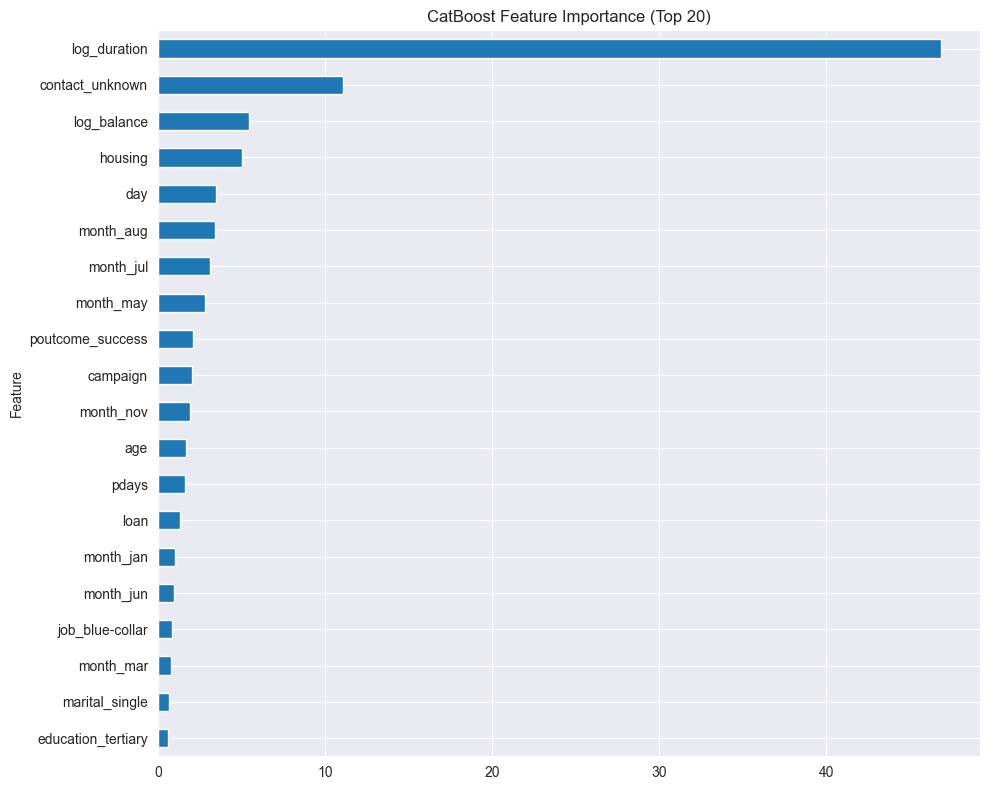

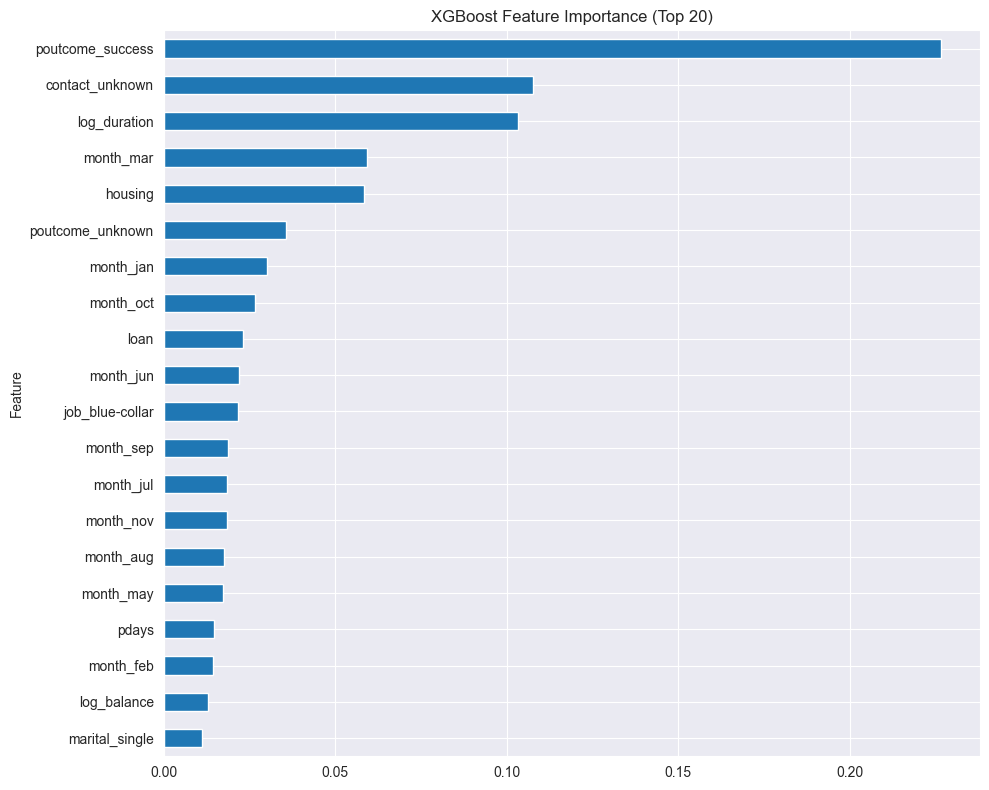

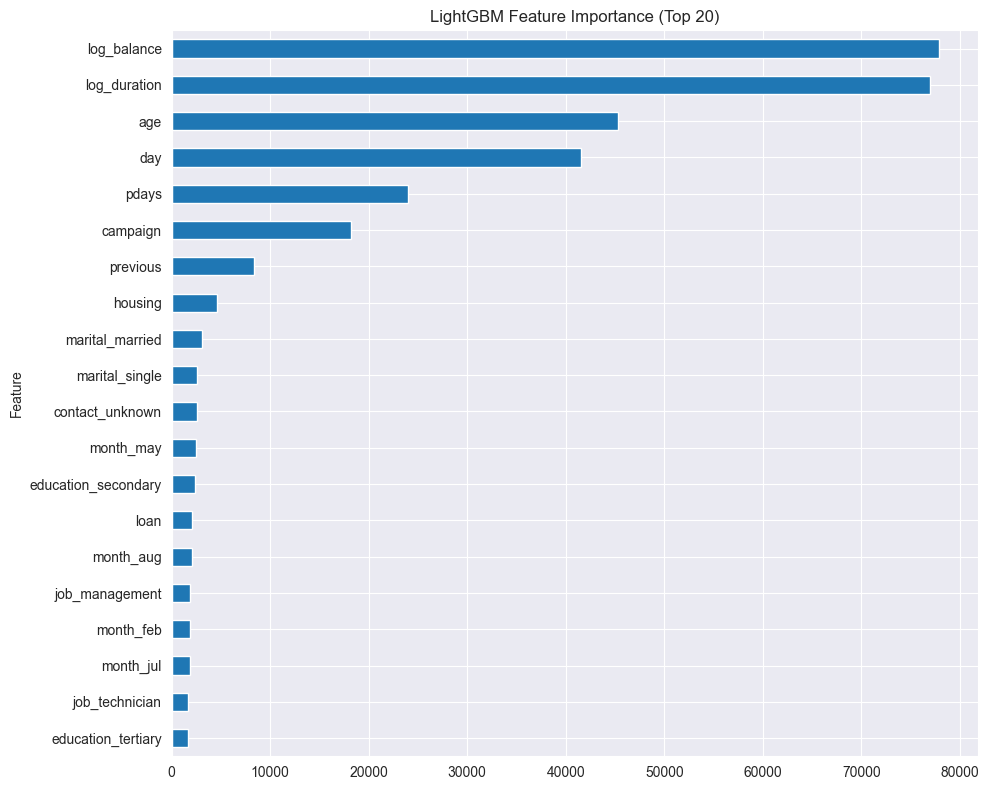

In [28]:
# ---- Plot Top 20 Features ----

# CatBoost
plt.figure(figsize=(10, 8))
catboost_importance_df.head(20).plot.barh(
    x='Feature', y='Importance',
    title='CatBoost Feature Importance (Top 20)',
    legend=False, ax=plt.gca()
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# XGBoost
plt.figure(figsize=(10, 8))
xgb_importance_df.head(20).plot.barh(
    x='Feature', y='Importance',
    title='XGBoost Feature Importance (Top 20)',
    legend=False, ax=plt.gca()
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# LightGBM
plt.figure(figsize=(10, 8))
lgbm_importance_df.head(20).plot.barh(
    x='Feature', y='Importance',
    title='LightGBM Feature Importance (Top 20)',
    legend=False, ax=plt.gca()
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Prepare test features by dropping the 'id' column if it exists
test_features = test_df.drop(columns=['id'], errors='ignore')


test_pred_prob = lgbm_model.predict_proba(test_features)[:, 1]


# Assuming you have an ID column saved before dropping
submission = pd.DataFrame({
    'id': test_df['id'],
    'y': test_pred_prob
})

submission.to_csv('submission.csv', index=False)
print("Submission saved!")